# Imports

In [1]:
import numpy as np                     
import pandas as pd
import random as rand
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt       
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.patches as patches
from matplotlib.lines import Line2D

import braingeneers                  
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster
import braingeneers.data.datasets_electrophysiology as ephys
from multiprocessing import Pool
from tqdm import tqdm

from human_hip import spike_data

# Data

In [2]:
dataset1 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')
dataset2 = spike_data.read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112723_hckcr1_21841_120323_base_acqm.zip" )

/tmp/ipykernel_12220/1586327698.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  dataset1 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')


# Code

In [3]:
# Helper functions

# Function to calculate the mean firing rates for each neuron
def calculate_mean_firing_rates(spike_data):
    # Compute mean firing rates for each neuron
    firing_rates = [len(train) / spike_data.length for train in spike_data.train]
    return firing_rates

# Function to calculate positions of neurons
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

# Function to calculate distances and angles between neurons
def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))
    
    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)
    
    return distances, angles

def create_reverse_rank_lookup(event_ranks):
    """
    Create a reverse lookup table for event ranks.
    
    Parameters:
    - event_ranks: A dictionary mapping (neuron_id, spike_time) to event rank.
    
    Returns:
    - A dictionary mapping event rank to (neuron_id, spike_time).
    """
    reverse_lookup = {rank: (neuron_id, spike_time) for (neuron_id, spike_time), rank in event_ranks.items()}
    return reverse_lookup 

# Function to order the events by rank
def calculate_event_ranks(spike_data, precision=5):
    # Flatten the list of spikes, rounding spike times, and sort by time
    # Include the original index of each spike for uniqueness
    all_spikes = [(neuron_id, round(spike_time, precision), idx) 
                  for neuron_id, spikes in enumerate(spike_data.train) 
                  for idx, spike_time in enumerate(spikes)]
                  
    # Sort by neuron_id, then rounded spike time, then original index
    all_spikes_sorted = sorted(all_spikes, key=lambda x: (x[1], x[0], x[2]))
    
    # Generate a dictionary with event rank as key, (neuron_id, spike_time) as value
    ranks = {rank: (neuron_id, spike_time) for rank, (neuron_id, spike_time, _) in enumerate(all_spikes_sorted)}
    
    print(f"Total unique events: {len(ranks)}")
    
    return ranks

# Function to compute pairs of neurons that are close to each other
def precompute_close_neurons(distances, window_size=17.5):
    # Initialize a dictionary to store the indices of close neurons for each neuron
    close_neurons = {}
    
    # Get the total number of neurons based on the distances matrix
    num_neurons = distances.shape[0]
    
    # Iterate over each neuron to find its close neighbors
    for i in range(num_neurons):
        # List comprehension to find neurons within the specified window size
        # Excludes the current neuron itself (i != j) and checks the distance condition
        close_neurons[i] = [
            j for j in range(num_neurons) 
            if i != j and distances[i, j] < window_size
        ]
        
    return close_neurons

# Function to compute the midpoints of bins
def compute_bin_midpoints(bins):
    midpoints = (bins[:-1] + bins[1:]) / 2
    return midpoints

In [4]:
# Functions to create, average and subtract histograms

# Function to create histograms for each event
def create_histograms_for_events(spike_data, event_ranks, spatial_range=(82, 1092), time_window_rank=30, bins=6):
    total_events = len(event_ranks)

    histograms_for_each_event = {}

    distances = precalculate_distances_angles(get_neuron_positions(spike_data))[0]
    angles = precalculate_distances_angles(get_neuron_positions(spike_data))[1]

    # distance_bins = np.linspace(0, np.max(distances), bins+1)
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)
    # angle_bins[-1] += 1e-10  # Make sure the last bin edge is included

    print_every_n = max(total_events // 10, 1)  # Update progress every 10% or at least once
    
    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id + 1}/{total_events}...")
            
        start_rank = max(0, current_event_id - time_window_rank)
        end_rank = min(total_events, current_event_id + time_window_rank + 1)

        event_distances, event_angles = [], []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            if other_event_id == current_event_id:
                continue

            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            angle = angles[current_neuron_id, other_neuron_id]

            if spatial_range[0] < distance < spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)

        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_for_each_event[current_event_id] = {
            'distance': distance_hist,
            'angle': angle_hist
        }
    
    print("Processing complete")
    return histograms_for_each_event

# Function to average histograms
def apply_sliding_window_average(spike_data, event_histograms, window_width=17.5, bins=6):
    smoothed_histograms = {}
    total_events = len(event_histograms)
    time_window_rank = 30
    distances = precalculate_distances_angles(get_neuron_positions(spike_data))[0]
    angles = precalculate_distances_angles(get_neuron_positions(spike_data))[1]
    event_ranks = calculate_event_ranks(spike_data)
    close_neurons = precompute_close_neurons(precalculate_distances_angles(get_neuron_positions(spike_data))[0], window_size=window_width)
    print_every_n = max(len(event_ranks) // 10, 1)  # Update progress every 10% or at least once

    count = 0

    for current_event_id, histograms in event_histograms.items():
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id + 1}/{len(event_histograms)}...")

        # current_neuron_id = event_ranks[event_id][0]

        # Initialize summed histogram for the current event
        summed_histogram = {'distance': np.zeros(bins), 'angle': np.zeros(bins)}
        summed_histogram_count = 1

        # Add the histograms of the current event to the sum
        summed_histogram['distance'] += histograms['distance']
        summed_histogram['angle'] += histograms['angle']

        start_rank = max(0, current_event_id - time_window_rank)
        end_rank = min(total_events, current_event_id + time_window_rank + 1)

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            if other_event_id == current_event_id:
                continue
            
            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            angle = angles[current_neuron_id, other_neuron_id]

            if distance < window_width / 2:
                summed_histogram['distance'] += event_histograms[other_event_id]['distance']
                summed_histogram['angle'] += event_histograms[other_event_id]['angle']
                summed_histogram_count += 1

        if summed_histogram_count > 0:
            smoothed_histograms[current_event_id] = {
                'distance': np.round(summed_histogram['distance'] / summed_histogram_count, 3),
                'angle': np.round(summed_histogram['angle'] / summed_histogram_count, 3)
            }

    return smoothed_histograms

# Function to subtract averaged histograms
def subtract_average_histograms(spike_data, averaged_histograms, window=336, bins=6):
    final_histograms = {}
    window_histograms = apply_sliding_window_average(spike_data, averaged_histograms, window_width=window, bins=bins)

    final_histograms = {event_id: {
        'distance': np.maximum(0, np.round(averaged_histograms[event_id]['distance'] - window_histograms[event_id]['distance'], 3)),
        'angle': np.maximum(0, np.round(averaged_histograms[event_id]['angle'] - window_histograms[event_id]['angle'], 4))
    } for event_id in averaged_histograms}

    return final_histograms

In [5]:
# Functions to take histograms of distances and angles for each event and compute average distance and angle per neuron

# Function to compute the average angle from a histogram - using trigonometry
def compute_average_angle_from_histogram(angle_hist):
    bin_width = 360 / len(angle_hist)
    bin_midpoints = np.arange(0, 360, bin_width) + bin_width / 2
    bin_midpoints_radians = np.radians(bin_midpoints)

    x_components = angle_hist * np.cos(bin_midpoints_radians)
    y_components = angle_hist * np.sin(bin_midpoints_radians)

    x_mean = np.sum(x_components) / np.sum(angle_hist)
    y_mean = np.sum(y_components) / np.sum(angle_hist)

    # Compute the arctangent of the mean vector components to get the average angle in radians
    average_angle_radians = np.arctan2(y_mean, x_mean)

    # Normalize the average angle to be within 0 to 2*pi radians
    if average_angle_radians < 0:
        average_angle_radians += 2 * np.pi

    # Return the average angle in radians
    return average_angle_radians

# Function to take final histograms and calculate the average distance and angle for each event
def compute_average_distance_angle(final_histograms, bins=6):
    average_distances_angles = {}

    distance_midpoints = compute_bin_midpoints(np.linspace(82, 1092, bins+1))
    angle_midpoints = compute_bin_midpoints(np.linspace(0, 2*np.pi, bins+1))

    angle_midpoints_degrees = np.degrees(angle_midpoints)

    # print(angle_midpoints_degrees)

    for event_id, histograms in final_histograms.items():
        distance_hist = histograms['distance']
        angle_hist = histograms['angle']

        # Compute average distance
        distance_sum = np.sum(distance_hist * distance_midpoints)
        distance_count = np.sum(distance_hist)
        average_distance = distance_sum / distance_count if distance_count != 0 else 0

        # Compute average angle
        average_angle = compute_average_angle_from_histogram(angle_hist)

        # normalized_average_angle = average_angle % (2 * np.pi)

        average_distances_angles[event_id] = {'distance': average_distance, 'angle': average_angle}

    return average_distances_angles

# Function to take the average distance and angle for each event and compile them by neuron
def all_events_per_neuron(spike_data, average_distances_angles_per_event):
    all_events_per_neuron = {}

    event_ranks = calculate_event_ranks(spike_data)
    for event_id, averages in average_distances_angles_per_event.items():
        neuron_id = event_ranks[event_id][0]
        if neuron_id not in all_events_per_neuron:
            all_events_per_neuron[neuron_id] = []
        all_events_per_neuron[neuron_id].append(averages)

    return all_events_per_neuron

# Function to compute the average distance and angle for each neuron
def average_events_per_neuron(spike_data, average_distances_angles_per_event):
    events_per_neuron = all_events_per_neuron(spike_data, average_distances_angles_per_event)
    positions = get_neuron_positions(spike_data)

    average_events_per_neuron = {}
    for neuron_id, events in events_per_neuron.items():
        angles = [event['angle'] for event in events]
        distances = [event['distance'] for event in events]

        # Calculate vector components
        x_components = [distance * np.cos(angle) for distance, angle in zip(distances, angles)]
        y_components = [distance * np.sin(angle) for distance, angle in zip(distances, angles)]

        # Calculate average vector components
        x_mean = np.mean(x_components)
        y_mean = np.mean(y_components)

        # Convert average vector components to polar coordinates
        average_distance = np.sqrt(x_mean**2 + y_mean**2)
        average_angle = np.arctan2(y_mean, x_mean)

        # # Normalize the average angle to be within 0 to 2*pi radians
        # if average_angle < 0:
        #     average_angle += 2 * np.pi

        average_events_per_neuron[neuron_id] = {'distance': average_distance, 'angle': average_angle, 'position': positions[neuron_id]}

    return average_events_per_neuron

In [10]:
# Function to plot the data

def plot_data(data):
    """
    Plots data points with arrows indicating direction and distance.
    Points with 'nan' angles are skipped in arrow plotting.

    Parameters:
    - data: A dictionary where each key is an identifier and each value is a dictionary
            containing 'distance', 'angle', and 'position'.
    """
    # Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
    fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size for better visibility
    for key, value in data.items():
        position = np.array(value['position'])  # Ensure position is a numpy array
        angle = value['angle']
        distance = value['distance'] # Scaling down the distance for better visualization

        # Plotting the point in red
        ax.plot(position[0], position[1], 'o', color='red')

        # Skip plotting the arrow if angle is nan
        if not np.isnan(angle):
            # Calculate the end point of the arrow
            end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            
            # Plotting the arrow with narrower and less bold appearance
            ax.annotate('', xy=end_point, xytext=position,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

    ax.set_aspect('equal')
    plt.title("Spatial activity profile")
    plt.show()

def plot_polar(results):
    """
    Plots the angles and distances from the results on a polar plot.

    Parameters:
    - results: A dictionary where each key is an identifier and each value is a dictionary 
               with 'angle' and 'distance' keys.
    """
    # Extracting angles and distances
    angles = [result['angle'] for result in results.values()]
    distances = [result['distance'] for result in results.values()]

    # Assuming angles are in radians. Uncomment and adjust if conversion is needed.
    # angles = np.radians(np.array(angles))

    # Create polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.scatter(angles, distances)

    # Display the plot
    plt.show()

# Dataset 1

In [7]:
histograms1 = create_histograms_for_events(dataset1, calculate_event_ranks(dataset1), spatial_range=(0, 500), time_window_rank=30, bins=6)
# averaged_histograms1 = apply_sliding_window_average(dataset1, histograms1, window_width=17.5*2, bins=6)
# final_histograms1 = subtract_average_histograms(dataset1, averaged_histograms1, window=336*2, bins=6)

Total unique events: 113477
Processing event 1/113477...


/tmp/ipykernel_12220/858225385.py:14: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing event 11348/113477...
Processing event 22695/113477...
Processing event 34042/113477...
Processing event 45389/113477...
Processing event 56736/113477...
Processing event 68083/113477...
Processing event 79430/113477...
Processing event 90777/113477...
Processing event 102124/113477...
Processing event 113471/113477...
Processing complete


In [8]:
average_events_per_neuron_test = average_events_per_neuron(dataset1, compute_average_distance_angle(histograms1, bins=6))

# average_events_basic = average_events_per_neuron(dataset1, compute_average_distance_angle(histograms1, bins=6))
# average_events_advanced = average_events_per_neuron(dataset1, compute_average_distance_angle(final_histograms1, bins=6))

/tmp/ipykernel_12220/3102381622.py:12: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_12220/3102381622.py:13: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)


Total unique events: 113477


/tmp/ipykernel_12220/858225385.py:14: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


# Average distance and direction per neuron - estimate of direction and distance toward center of mass of coincident activity

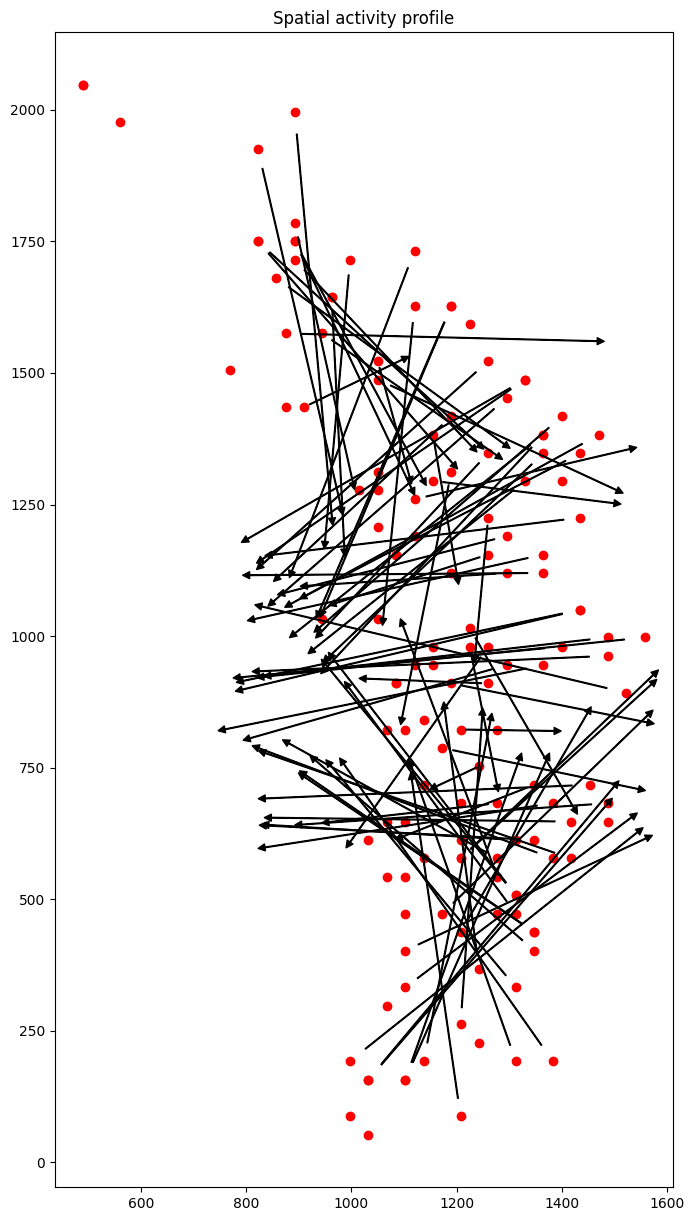

In [11]:
plot_data(average_events_per_neuron_test)

# Average distance and direction per neuron - identification of local structures

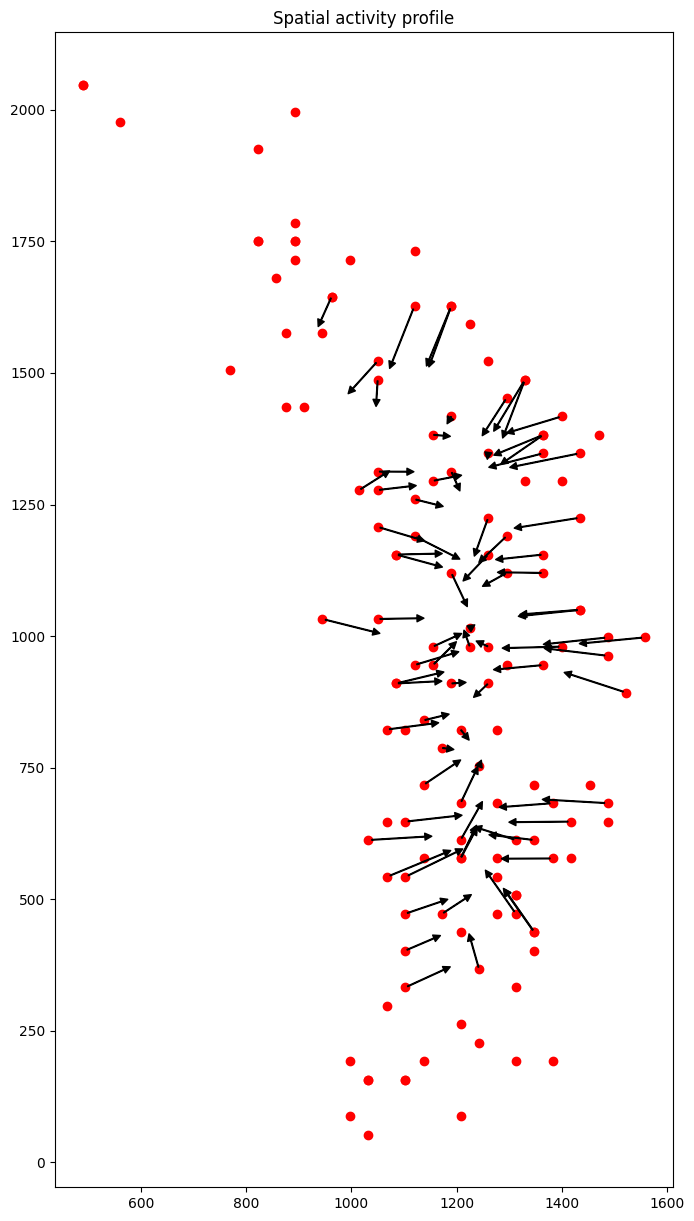

In [75]:
plot_data(average_events_advanced)

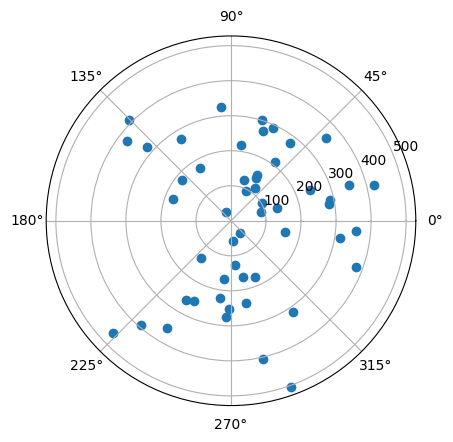

In [59]:
plot_polar(average_events_advanced)

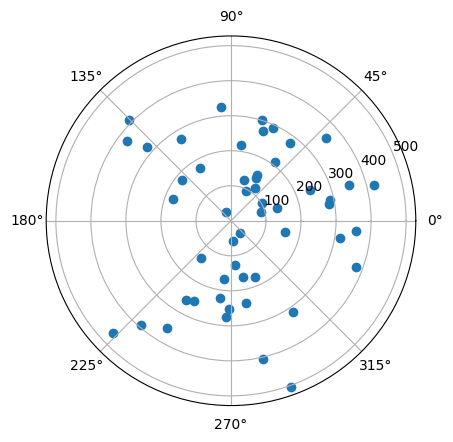

In [27]:
plot_polar(average_events_advanced)

# Dataset 2

In [43]:
histograms2 = create_histograms_for_events(dataset2, calculate_event_ranks(dataset2))
averaged_histograms2 = apply_sliding_window_average(dataset2, histograms2)
final_histograms2 = subtract_average_histograms(dataset2, averaged_histograms2)
average_distance_angles2 = compute_average_distance_angle(histograms2)
average_events2 = average_events_per_neuron(dataset2, average_distance_angles2)

Total unique events: 338136
Processing event 1/338136...


/tmp/ipykernel_1459/4269173223.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing event 3382/338136...
Processing event 6763/338136...
Processing event 10144/338136...
Processing event 13525/338136...
Processing event 16906/338136...
Processing event 20287/338136...
Processing event 23668/338136...
Processing event 27049/338136...
Processing event 30430/338136...
Processing event 33811/338136...
Processing event 37192/338136...
Processing event 40573/338136...
Processing event 43954/338136...
Processing event 47335/338136...
Processing event 50716/338136...
Processing event 54097/338136...
Processing event 57478/338136...
Processing event 60859/338136...
Processing event 64240/338136...
Processing event 67621/338136...
Processing event 71002/338136...
Processing event 74383/338136...
Processing event 77764/338136...
Processing event 81145/338136...
Processing event 84526/338136...
Processing event 87907/338136...
Processing event 91288/338136...
Processing event 94669/338136...
Processing event 98050/338136...
Processing event 101431/338136...
Processing 

/tmp/ipykernel_1459/2161906792.py:9: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_1459/2161906792.py:10: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)


Total unique events: 338136


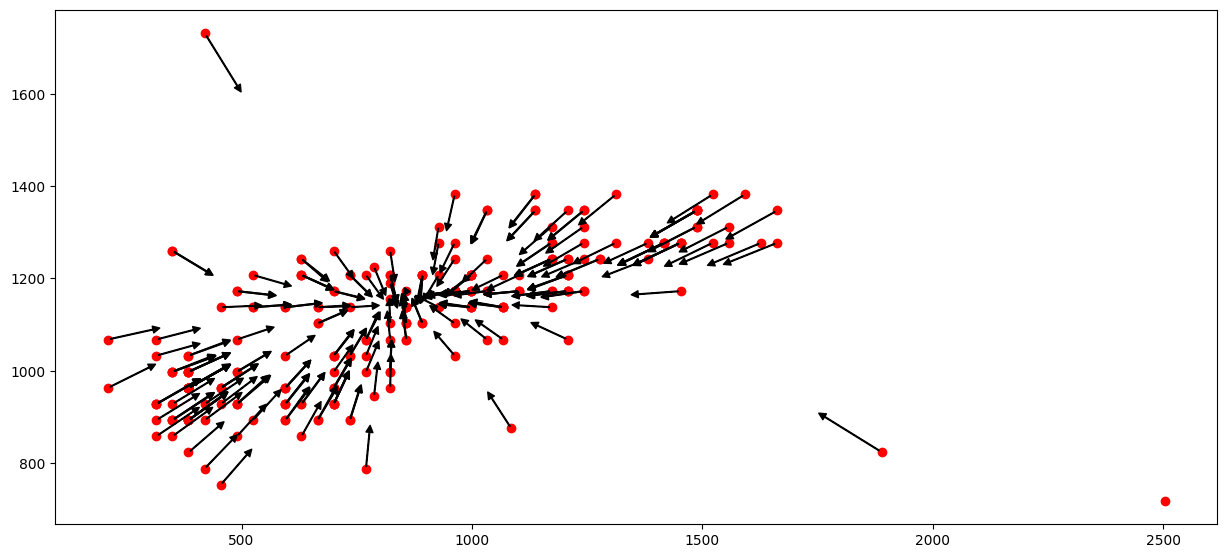

In [46]:
plot_data(average_events2)

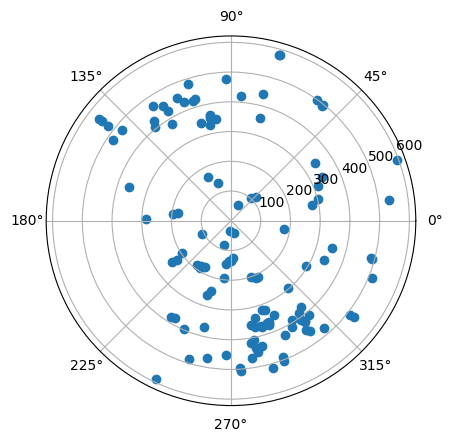

In [21]:
plot_polar(average_events2)

In [ ]:
def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))
    
    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)
    
    return distances, angles

In [56]:
neuron_position0 = [0, 100]
neuron_position1 = [100, 100]
neuron_positions = np.array([neuron_position0, neuron_position1])

distances, angles = precalculate_distances_angles(neuron_positions)

In [58]:
angles

array([[0.        , 3.14159265],
       [0.        , 0.        ]])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

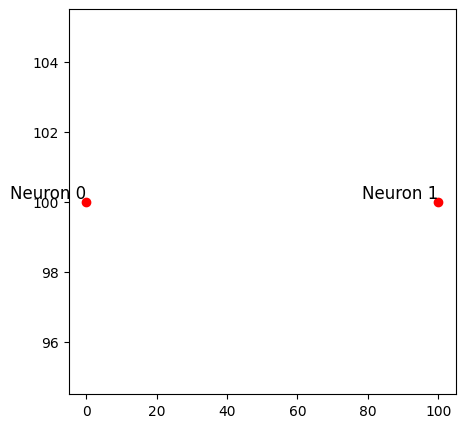

In [57]:
# Plotting the angles
plt.figure(figsize=(5, 5))
plt.scatter(neuron_positions[:, 0], neuron_positions[:, 1], color='red')
for i in range(len(neuron_positions)):
    plt.text(neuron_positions[i, 0], neuron_positions[i, 1], f'Neuron {i}', fontsize=12, ha='right', va='bottom')
for i in range(len(neuron_positions)):
    plt.arrow(neuron_positions[i, 0], neuron_positions[i, 1], 10 * np.cos(angles[i]), 10 * np.sin(angles[i]), head_width=5, head_length=5, fc='blue', ec='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Angles between Neurons')
plt.grid(True)
plt.axis('equal')
plt.show()

In [54]:
angles[0][1]

2.356194490192345

In [40]:
histograms = create_histograms_for_events(sd, calculate_event_ranks(sd))
averaged_histograms = apply_sliding_window_average(sd, histograms, window_width=(17.5*2), bins=6)
final_histograms = subtract_average_histograms(sd, averaged_histograms, window=(336*4), bins=6)

average_distances_angles = compute_average_distance_angle(histograms, bins=6)

Total unique events: 113477
Processing event 1/113477...
Processing event 1135/113477...


/tmp/ipykernel_74062/4269173223.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing event 2269/113477...
Processing event 3403/113477...
Processing event 4537/113477...
Processing event 5671/113477...
Processing event 6805/113477...
Processing event 7939/113477...
Processing event 9073/113477...
Processing event 10207/113477...
Processing event 11341/113477...
Processing event 12475/113477...
Processing event 13609/113477...
Processing event 14743/113477...
Processing event 15877/113477...
Processing event 17011/113477...
Processing event 18145/113477...
Processing event 19279/113477...
Processing event 20413/113477...
Processing event 21547/113477...
Processing event 22681/113477...
Processing event 23815/113477...
Processing event 24949/113477...
Processing event 26083/113477...
Processing event 27217/113477...
Processing event 28351/113477...
Processing event 29485/113477...
Processing event 30619/113477...
Processing event 31753/113477...
Processing event 32887/113477...
Processing event 34021/113477...
Processing event 35155/113477...
Processing event 

/tmp/ipykernel_74062/2161906792.py:9: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_74062/2161906792.py:10: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)


In [10]:
def all_events_per_neuron(spike_data, average_distances_angles_per_event):
    all_events_per_neuron = {}

    event_ranks = calculate_event_ranks(spike_data)
    for event_id, averages in average_distances_angles_per_event.items():
        neuron_id = event_ranks[event_id][0]
        if neuron_id not in all_events_per_neuron:
            all_events_per_neuron[neuron_id] = []
        all_events_per_neuron[neuron_id].append(averages)

    return all_events_per_neuron

def average_events_per_neuron(spike_data, average_distances_angles_per_event):
    events_per_neuron = all_events_per_neuron(spike_data, average_distances_angles_per_event)
    positions = get_neuron_positions(spike_data)

    average_events_per_neuron = {}
    for neuron_id, events in events_per_neuron.items():
        angles = [event['angle'] for event in events]
        distances = [event['distance'] for event in events]

        # Calculate vector components
        x_components = [distance * np.cos(angle) for distance, angle in zip(distances, angles)]
        y_components = [distance * np.sin(angle) for distance, angle in zip(distances, angles)]

        # Calculate average vector components
        x_mean = np.mean(x_components)
        y_mean = np.mean(y_components)

        # Convert average vector components to polar coordinates
        average_distance = np.sqrt(x_mean**2 + y_mean**2)
        average_angle = np.arctan2(y_mean, x_mean)

        # # Normalize the average angle to be within 0 to 2*pi radians
        # if average_angle < 0:
        #     average_angle += 2 * np.pi

        average_events_per_neuron[neuron_id] = {'distance': average_distance, 'angle': average_angle, 'position': positions[neuron_id]}

    return average_events_per_neuron

In [41]:
average_events_per_n = average_events_per_neuron(spike_data=sd, average_distances_angles_per_event=average_distances_angles)

Total unique events: 113477


/tmp/ipykernel_74062/4269173223.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


In [42]:
def plot_data(data):
    """
    Plots data points with arrows indicating direction and distance.
    Points with 'nan' angles are skipped in arrow plotting.

    Parameters:
    - data: A dictionary where each key is an identifier and each value is a dictionary
            containing 'distance', 'angle', and 'position'.
    """
    # Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
    fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size for better visibility
    for key, value in data.items():
        position = np.array(value['position'])  # Ensure position is a numpy array
        angle = value['angle']
        distance = value['distance'] / 5  # Scaling down the distance for better visualization

        # Plotting the point in red
        ax.plot(position[0], position[1], 'o', color='red')

        # Skip plotting the arrow if angle is nan
        if not np.isnan(angle):
            # Calculate the end point of the arrow
            end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            
            # Plotting the arrow with narrower and less bold appearance
            ax.annotate('', xy=end_point, xytext=position,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

    ax.set_aspect('equal')
    plt.show()

def plot_polar(results):
    """
    Plots the angles and distances from the results on a polar plot.

    Parameters:
    - results: A dictionary where each key is an identifier and each value is a dictionary 
               with 'angle' and 'distance' keys.
    """
    # Extracting angles and distances
    angles = [result['angle'] for result in results.values()]
    distances = [result['distance'] for result in results.values()]

    # Assuming angles are in radians. Uncomment and adjust if conversion is needed.
    # angles = np.radians(np.array(angles))

    # Create polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.scatter(angles, distances)

    # Display the plot
    plt.show()

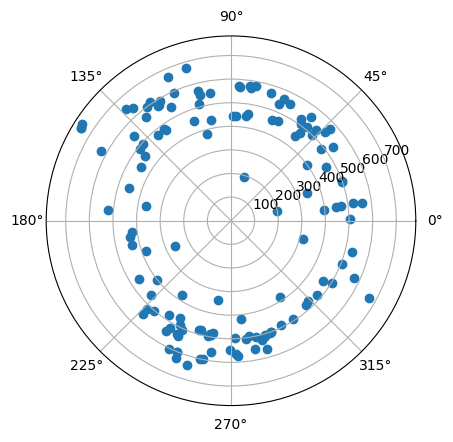

In [43]:
plot_polar(average_events_per_n)

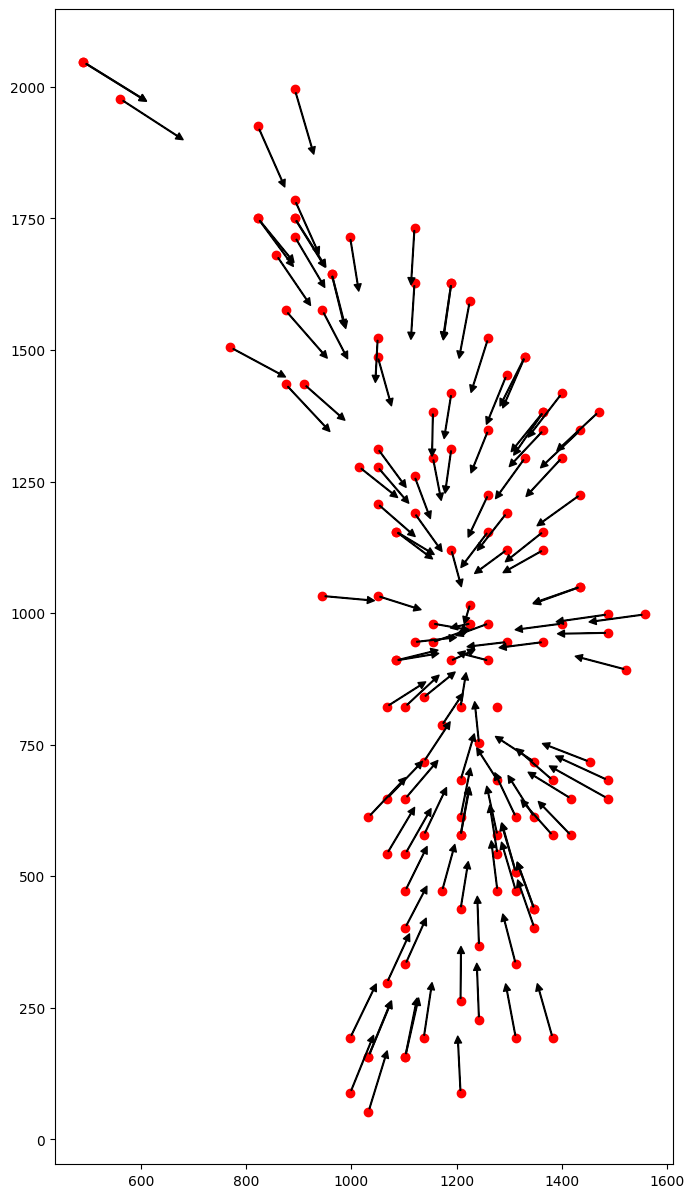

In [44]:
plot_data(average_events_per_n)

In [40]:
def compute_average_angle_from_histogram(angle_hist):
    bin_width = 360 / len(angle_hist)
    bin_midpoints = np.arange(0, 360, bin_width) + bin_width / 2
    bin_midpoints_radians = np.radians(bin_midpoints)

    x_components = angle_hist * np.cos(bin_midpoints_radians)
    y_components = angle_hist * np.sin(bin_midpoints_radians)

    x_mean = np.sum(x_components) / np.sum(angle_hist)
    y_mean = np.sum(y_components) / np.sum(angle_hist)

    # Compute the arctangent of the mean vector components to get the average angle in radians
    average_angle_radians = np.arctan2(y_mean, x_mean)

    # Normalize the average angle to be within 0 to 2*pi radians
    if average_angle_radians < 0:
        average_angle_radians += 2 * np.pi

    # Return the average angle in radians
    return average_angle_radians


# Function to take final histograms and calculate the average distance and angle for each event
def compute_average_distance_angle(final_histograms, bins=6):
    average_distances_angles = {}

    distance_midpoints = compute_bin_midpoints(np.linspace(82, 1092, bins+1))
    angle_midpoints = compute_bin_midpoints(np.linspace(0, 2*np.pi, bins+1))

    angle_midpoints_degrees = np.degrees(angle_midpoints)

    # print(angle_midpoints_degrees)

    for event_id, histograms in final_histograms.items():
        distance_hist = histograms['distance']
        angle_hist = histograms['angle']

        # Compute average distance
        distance_sum = np.sum(distance_hist * distance_midpoints)
        distance_count = np.sum(distance_hist)
        average_distance = distance_sum / distance_count if distance_count != 0 else 0

        # Compute average angle
        average_angle = compute_average_angle_from_histogram(angle_hist)

        normalized_average_angle = average_angle % (2 * np.pi)

        average_distances_angles[event_id] = {'distance': average_distance, 'angle': average_angle}

    return average_distances_angles

# Function to calculate the distances and angles for each neuron
def calculate_stats_per_neuron(spike_data, histograms):
    distances_angles_per_neuron = {}
    event_ranks = calculate_event_ranks(spike_data)
    avg_dist_angles = compute_average_distance_angle(histograms, bins=6)

    for event_id in avg_dist_angles:
        neuron_id = event_ranks[event_id][0]
        if neuron_id not in distances_angles_per_neuron:
            distances_angles_per_neuron[neuron_id] = []
        distances_angles_per_neuron[neuron_id].append(avg_dist_angles[event_id])
    
    return distances_angles_per_neuron

# # Function to calculate the average distance and angle for each neuron
# def averages_per_postion(distances_angles_per_neuron):
#     avg_distances_angles = {}
#     neuron_positions = get_neuron_positions(sd)
#     for neuron_id, stats in distances_angles_per_neuron.items():
#         avg_distance = np.mean([stat['distance'] for stat in stats])
#         avg_angle = np.mean([stat['angle'] for stat in stats])
#         avg_distances_angles[neuron_id] = {'distance': avg_distance, 'angle': avg_angle, 'position': neuron_positions[neuron_id]}
#     return avg_distances_angles

def averages_per_position(distances_angles_per_neuron):
    avg_distances_angles = {}
    neuron_positions = get_neuron_positions(sd)  # Assuming this function is defined elsewhere
    for neuron_id, stats in distances_angles_per_neuron.items():
        avg_distance = np.mean([stat['distance'] for stat in stats])
        
        # Convert angles to radians for vector calculations
        angles_radians = np.radians([stat['angle'] for stat in stats])
        
        # Calculate mean vector components
        x_components = np.cos(angles_radians)
        y_components = np.sin(angles_radians)
        x_mean = np.mean(x_components)
        y_mean = np.mean(y_components)
        
        # Compute the arctangent of the mean vector components to get the average angle in radians
        avg_angle_radians = np.arctan2(y_mean, x_mean)
        
        # Convert the average angle back to degrees if needed
        avg_angle_degrees = np.degrees(avg_angle_radians)
        
        # Adjust the angle to be within the range [0, 360) if necessary
        if avg_angle_degrees < 0:
            avg_angle_degrees += 360
        
        avg_distances_angles[neuron_id] = {'distance': avg_distance, 'angle': avg_angle_degrees, 'position': neuron_positions[neuron_id]}
        
    return avg_distances_angles

In [9]:
histograms = create_histograms_for_events(sd, calculate_event_ranks(sd), spatial_range=(82, 1092), time_window_rank=30, bins=6)
averaged_histograms = apply_sliding_window_average(sd, histograms, window_width=17.5, bins=6)
final_histograms = subtract_average_histograms(sd, averaged_histograms, window=336, bins=6)

Total unique events: 113477
Processing event 1/113477...
Processing event 1135/113477...


/tmp/ipykernel_60203/4269173223.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing event 2269/113477...
Processing event 3403/113477...
Processing event 4537/113477...
Processing event 5671/113477...
Processing event 6805/113477...
Processing event 7939/113477...
Processing event 9073/113477...
Processing event 10207/113477...
Processing event 11341/113477...
Processing event 12475/113477...
Processing event 13609/113477...
Processing event 14743/113477...
Processing event 15877/113477...
Processing event 17011/113477...
Processing event 18145/113477...
Processing event 19279/113477...
Processing event 20413/113477...
Processing event 21547/113477...
Processing event 22681/113477...
Processing event 23815/113477...
Processing event 24949/113477...
Processing event 26083/113477...
Processing event 27217/113477...
Processing event 28351/113477...
Processing event 29485/113477...
Processing event 30619/113477...
Processing event 31753/113477...
Processing event 32887/113477...
Processing event 34021/113477...
Processing event 35155/113477...
Processing event 

In [41]:
stats_per_neuron = calculate_stats_per_neuron(sd, final_histograms)
average_distances_angles = averages_per_postion(stats_per_neuron)

stats_per_neuron2 = calculate_stats_per_neuron(sd, histograms)
average_distances_angles2 = averages_per_postion(stats_per_neuron2)

stats_per_neuron3 = calculate_stats_per_neuron(sd, averaged_histograms)
average_distances_angles3 = averages_per_postion(stats_per_neuron3)

Total unique events: 113477


/tmp/ipykernel_60203/3023211411.py:9: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_60203/3023211411.py:10: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)
/tmp/ipykernel_60203/4269173223.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Total unique events: 113477
Total unique events: 113477


In [11]:
def plot_data(data):
    """
    Plots data points with arrows indicating direction and distance.
    Points with 'nan' angles are skipped in arrow plotting.

    Parameters:
    - data: A dictionary where each key is an identifier and each value is a dictionary
            containing 'distance', 'angle', and 'position'.
    """
    # Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
    fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size for better visibility
    for key, value in data.items():
        position = np.array(value['position'])  # Ensure position is a numpy array
        angle = value['angle']
        distance = value['distance'] / 8  # Scaling down the distance for better visualization

        # Plotting the point in red
        ax.plot(position[0], position[1], 'o', color='red')

        # Skip plotting the arrow if angle is nan
        if not np.isnan(angle):
            # Calculate the end point of the arrow
            end_point = position + np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            
            # Plotting the arrow with narrower and less bold appearance
            ax.annotate('', xy=end_point, xytext=position,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

    ax.set_aspect('equal')
    plt.show()

def plot_polar(results):
    """
    Plots the angles and distances from the results on a polar plot.

    Parameters:
    - results: A dictionary where each key is an identifier and each value is a dictionary 
               with 'angle' and 'distance' keys.
    """
    # Extracting angles and distances
    angles = [result['angle'] for result in results.values()]
    distances = [result['distance'] for result in results.values()]

    # Assuming angles are in radians. Uncomment and adjust if conversion is needed.
    # angles = np.radians(np.array(angles))

    # Create polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.scatter(angles, distances)

    # Display the plot
    plt.show()


In [21]:
def plot_polar(results):
    """
    Plots the angles and distances from the results on a polar plot.

    Parameters:
    - results: A dictionary where each key is an identifier and each value is a dictionary 
               with 'angle' and 'distance' keys.
    """
    # Extracting angles and distances
    angles = [result['angle'] for result in results.values()]
    distances = [result['distance'] for result in results.values()]

    # Assuming angles are in radians. Uncomment and adjust if conversion is needed.
    # angles = np.radians(np.array(angles))

    # Create polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.scatter(angles, distances)

    # Display the plot
    plt.show()

In [43]:
compute_average_distance_angle(final_histograms, bins=6)

/tmp/ipykernel_60203/3023211411.py:9: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_60203/3023211411.py:10: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)


{0: {'distance': 502.83333333333337, 'angle': 0.5235987755982988},
 1: {'distance': 839.5, 'angle': nan},
 2: {'distance': 338.4453125, 'angle': 3.665191429188092},
 3: {'distance': 723.4138111791646, 'angle': 1.1878231359830715},
 4: {'distance': 0, 'angle': 3.665191429188092},
 5: {'distance': 684.806324110672, 'angle': 5.759586531581287},
 6: {'distance': 839.5, 'angle': 2.6179938779914944},
 7: {'distance': 516.4372218318108, 'angle': 3.8058562360940242},
 8: {'distance': 334.5, 'angle': 4.512332219559116},
 9: {'distance': 732.680047164975, 'angle': 6.283185307179586},
 10: {'distance': 772.0859312549959, 'angle': 5.976611601520165},
 11: {'distance': 529.9258835494534, 'angle': 3.7367127287378787},
 12: {'distance': 288.2037037037037, 'angle': 0.91538038700799},
 13: {'distance': 671.1666666666667, 'angle': 1.5707963267948966},
 14: {'distance': 367.91075450450455, 'angle': 4.71238898038469},
 15: {'distance': 810.7307210744979, 'angle': 4.848943187644391},
 16: {'distance': 733.

/tmp/ipykernel_60203/3023211411.py:9: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_60203/3023211411.py:10: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)


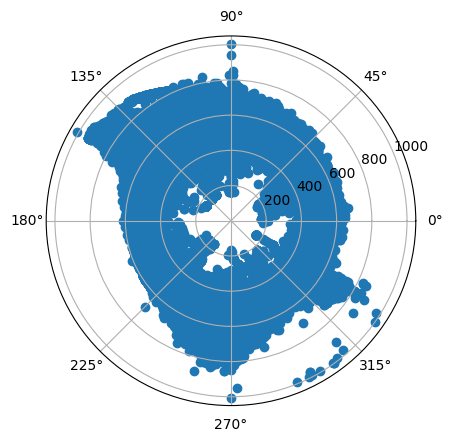

In [45]:
plot_polar(compute_average_distance_angle(histograms, bins=6))

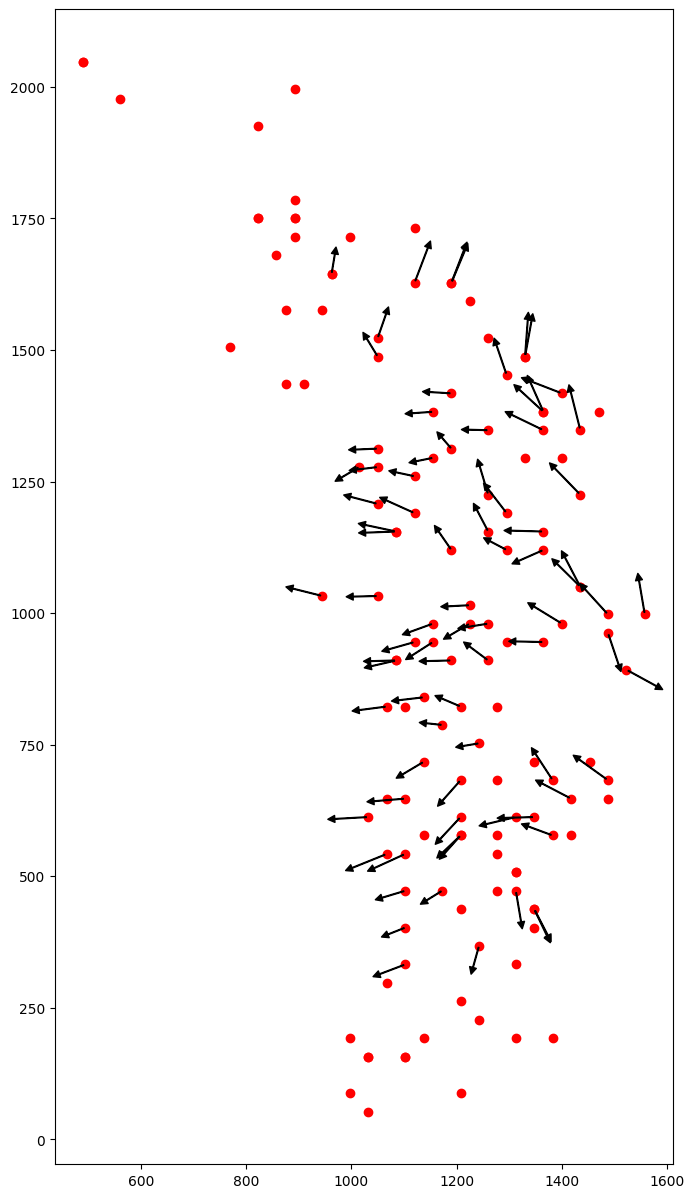

In [36]:
plot_data(average_distances_angles)

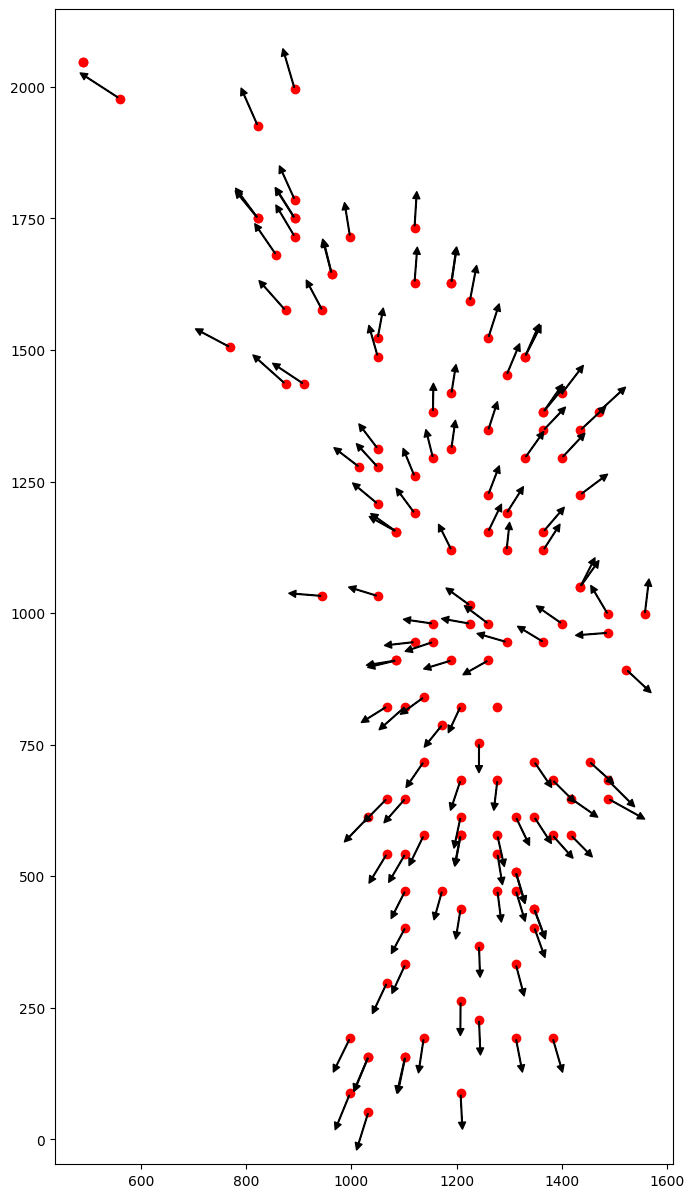

In [14]:
plot_data(average_distances_angles2)

In [25]:
avg_dist_angles = compute_average_distance_angle(final_histograms, bins=6)

[ 30.  90. 150. 210. 270. 330.]


/tmp/ipykernel_47801/711047810.py:9: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_47801/711047810.py:10: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)


In [29]:
distances_angles_per_neuron = calculate_stats_per_neuron(sd, final_histograms)

Total unique events: 113477
[ 30.  90. 150. 210. 270. 330.]


/tmp/ipykernel_47801/244665823.py:9: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_47801/244665823.py:10: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)


In [30]:
def averages_per_postion(distances_angles_per_neuron):
    avg_distances_angles = {}
    neuron_positions = get_neuron_positions(sd)
    for neuron_id, stats in distances_angles_per_neuron.items():
        avg_distance = np.mean([stat['distance'] for stat in stats])
        avg_angle = np.mean([stat['angle'] for stat in stats])
        avg_distances_angles[neuron_id] = {'distance': avg_distance, 'angle': avg_angle, 'position': neuron_positions[neuron_id]}
    return avg_distances_angles

In [45]:
results = averages_per_postion(distances_angles_per_neuron)

/tmp/ipykernel_47801/4269173223.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


In [33]:
results

{124: {'distance': 699.629635546041,
  'angle': nan,
  'position': array([1470. , 1382.5])},
 89: {'distance': 526.4626348158905,
  'angle': nan,
  'position': array([1417.5,  577.5])},
 1: {'distance': 390.4948272802454,
  'angle': 3.342527365073559,
  'position': array([1155., 1295.])},
 134: {'distance': 620.6776690481383,
  'angle': 1.8990838409107647,
  'position': array([1295. , 1452.5])},
 66: {'distance': 668.248845864895,
  'angle': nan,
  'position': array([1102.5,  157.5])},
 68: {'distance': 508.1058412952648,
  'angle': 2.0527681982362505,
  'position': array([1260., 1155.])},
 41: {'distance': 634.515506062354,
  'angle': nan,
  'position': array([ 910., 1435.])},
 3: {'distance': 448.0449707139252,
  'angle': 3.673470795462668,
  'position': array([1015. , 1277.5])},
 29: {'distance': 518.5236841753712,
  'angle': 3.7122696324067608,
  'position': array([1155.,  945.])},
 34: {'distance': 684.1736837360124,
  'angle': 2.5180714486424836,
  'position': array([1487.5,  682

In [42]:
def plot_data(data):
    """
    Plots data points with arrows indicating direction and distance.
    Points with 'nan' angles are skipped in arrow plotting.

    Parameters:
    - data: A dictionary where each key is an identifier and each value is a dictionary
            containing 'distance', 'angle', and 'position'.
    """
    # Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
    fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size for better visibility
    for key, value in data.items():
        position = np.array(value['position'])  # Ensure position is a numpy array
        angle = value['angle']
        distance = value['distance'] / 8  # Scaling down the distance for better visualization

        # Plotting the point in red
        ax.plot(position[0], position[1], 'o', color='red')

        # Skip plotting the arrow if angle is nan
        if not np.isnan(angle):
            # Calculate the end point of the arrow
            end_point = position + np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            
            # Plotting the arrow with narrower and less bold appearance
            ax.annotate('', xy=end_point, xytext=position,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

    ax.set_aspect('equal')
    plt.show()


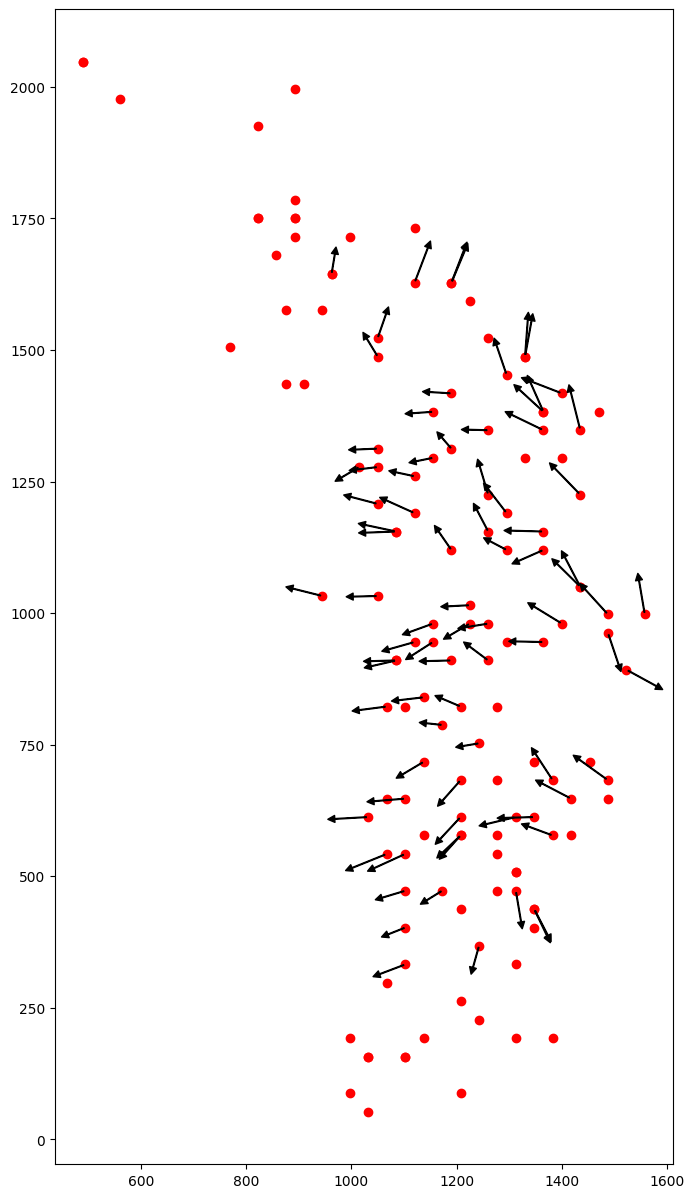

In [43]:
plot_data(data=results)

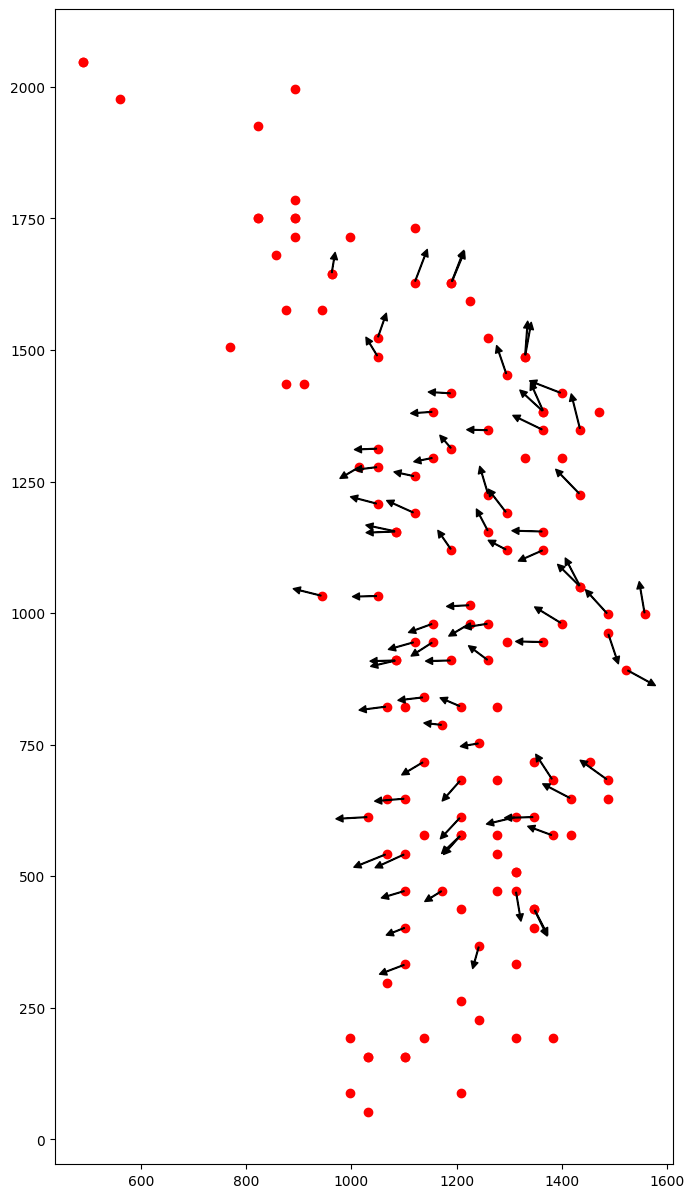

In [32]:
data = results

# Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size
for key, value in data.items():
    position = value['position']
    angle = value['angle']
    distance = value['distance'] / 10  # Scaling down the distance for better visualization on the plot
    
    # Calculate the end point of the arrow
    end_point = position + np.array([np.cos(angle) * distance, np.sin(angle) * distance])
    
    # Plotting the point in red
    ax.plot(position[0], position[1], 'o', color='red')
    
    # Plotting the arrow with narrower and less bold appearance
    ax.annotate('', xy=end_point, xytext=position, arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))
    
ax.set_aspect('equal')
plt.show()

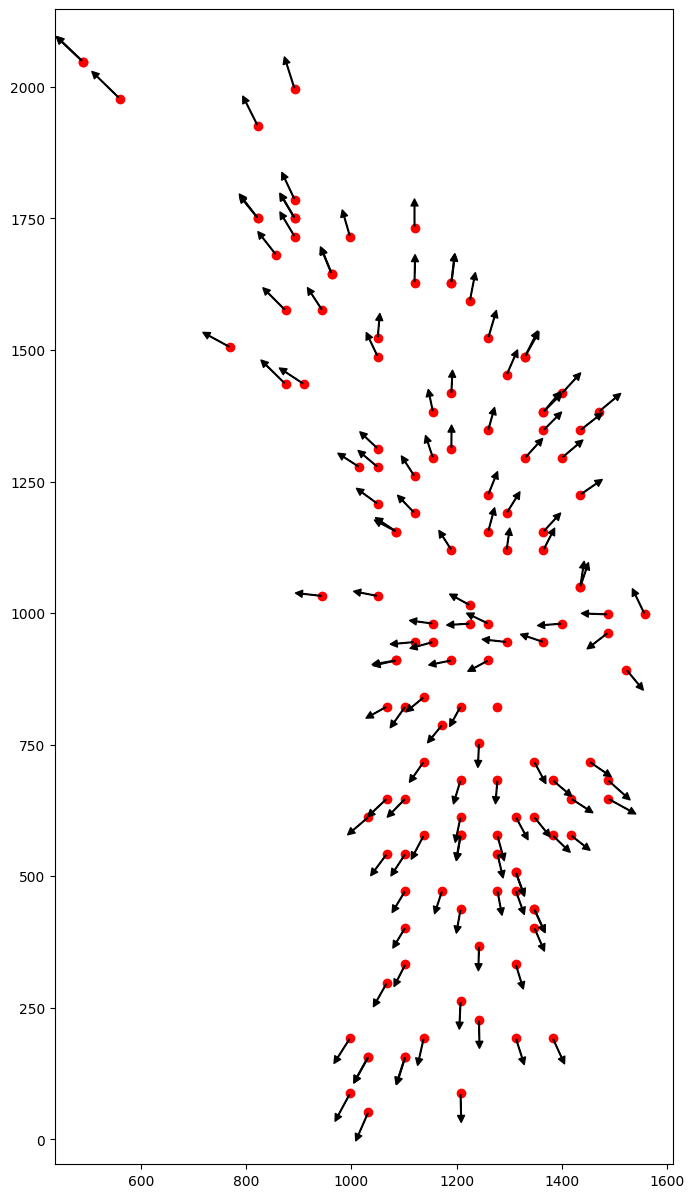

In [82]:
data = results_basic

# Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size
for key, value in data.items():
    position = value['position']
    angle = value['angle']
    distance = value['distance'] / 10  # Scaling down the distance for better visualization on the plot
    
    # Calculate the end point of the arrow
    end_point = position + np.array([np.cos(angle) * distance, np.sin(angle) * distance])
    
    # Plotting the point in red
    ax.plot(position[0], position[1], 'o', color='red')
    
    # Plotting the arrow with narrower and less bold appearance
    ax.annotate('', xy=end_point, xytext=position, arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))
    
ax.set_aspect('equal')
plt.show()

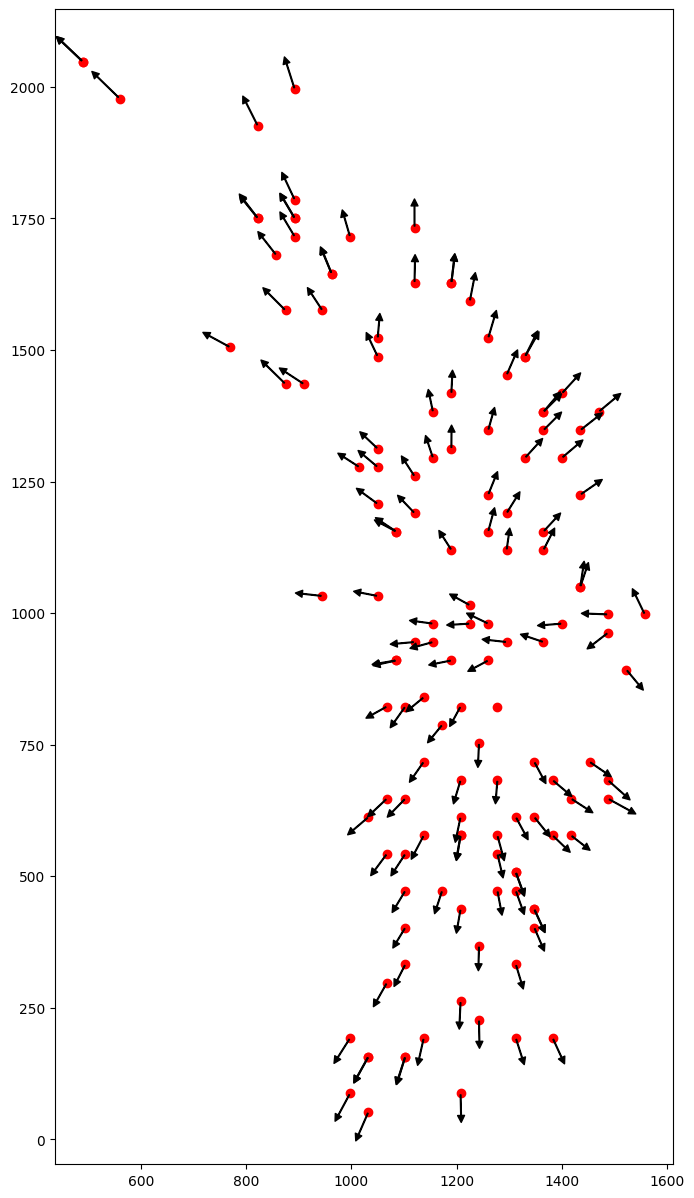

In [75]:
data = results

# Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size
for key, value in data.items():
    position = value['position']
    angle = value['angle']
    distance = value['distance'] / 10  # Scaling down the distance for better visualization on the plot
    
    # Calculate the end point of the arrow
    end_point = position + np.array([np.cos(angle) * distance, np.sin(angle) * distance])
    
    # Plotting the point in red
    ax.plot(position[0], position[1], 'o', color='red')
    
    # Plotting the arrow with narrower and less bold appearance
    ax.annotate('', xy=end_point, xytext=position, arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))
    
ax.set_aspect('equal')
plt.show()

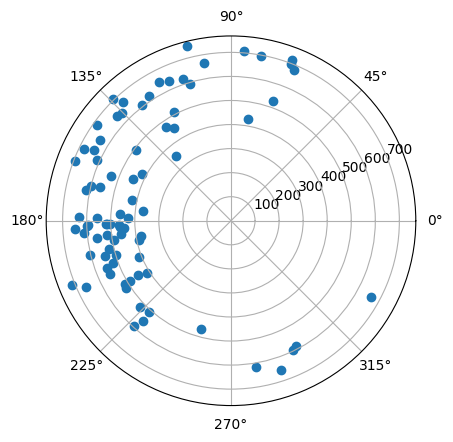

In [46]:
results = results # Extracting angles and distances

angles = [result['angle'] for result in results.values()]
distances = [result['distance'] for result in results.values()]

# # Convert angles to radians
# angles = np.array(angles)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(angles, distances)

plt.show()

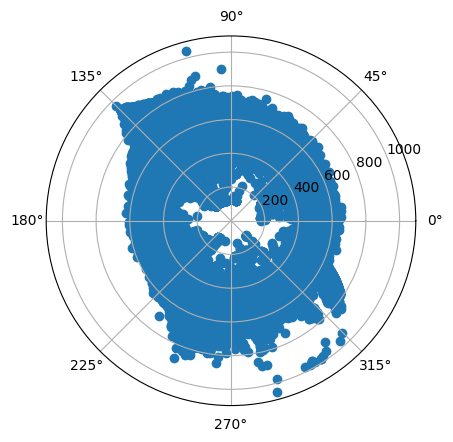

In [38]:
results = avg_dist_angles
# Extracting angles and distances

angles = [result['angle'] for result in results.values()]
distances = [result['distance'] for result in results.values()]

# # Convert angles to radians
# angles = np.array(angles)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(angles, distances)

plt.show()

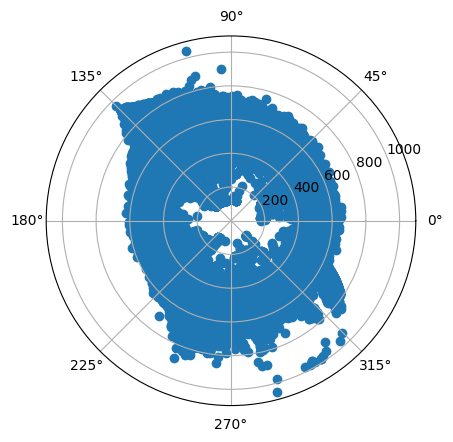

In [32]:
results = avg_dist_angles
# Extracting angles and distances

angles = [result['angle'] for result in results.values()]
distances = [result['distance'] for result in results.values()]

# # Convert angles to radians
# angles = np.array(angles)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(angles, distances)

plt.show()

In [25]:
total_non_whole = 0

# Iterate over the dictionary
for key, value in averaged_histograms.items():
    # Iterate over distance and angle arrays
    for array_name, array in value.items():
        num_not_whole = sum(1 for num in array if num < 0)
        total_non_whole += num_not_whole

print(f"Total number of elements across all arrays and entries that are not whole numbers or do not end in 0.5: {total_non_whole}")

Total number of elements across all arrays and entries that are not whole numbers or do not end in 0.5: 0
